In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import pgeocode
import cartopy.crs as ccrs
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

nomi = pgeocode.Nominatim("us")

In [3]:
owners = pd.read_csv("../kauai_county_owners.csv")
usa = gpd.read_file("../cb_2018_us_state_500k.zip")

In [4]:
NS_ZIP_CODES = [96722, 96754, 96746] # last one is more like Ko'olau
NS_owners = owners[owners.Zip.isin(NS_ZIP_CODES)].dropna(subset=["Zip", "OwnerZip"])
NS_owners["OwnerZip"] = NS_owners["OwnerZip"].astype(int)
NS_owners["Zip"] = NS_owners["Zip"].astype(int)

In [5]:
percent_same_zip = NS_owners.OwnerZip.isin(NS_ZIP_CODES).sum() / len(NS_owners)
print(f"{percent_same_zip: .1%} of properties have a mailing address within the north shore")

 68.1% of properties have a mailing address within the north shore


In [106]:
KAUAI_ZIP_CODES = [96746, 96766, 96756, 96741, 96754, 96722, 96714, 96752, 96705, 96796, 96765, 96703, 96716, 96747, 96769, 96751, 96715]
percent_off_island = 1 - NS_owners.OwnerZip.isin(KAUAI_ZIP_CODES).sum() / len(NS_owners)
print(f"{percent_off_island: .1%} of properties have a mailing address off-island")

 21.7% of properties have a mailing address off-island


In [165]:
percent_NS_out_of_all_hawaii = NS_owners.OwnerZip.isin(NS_ZIP_CODES).sum() / (NS_owners.OwnerState == "HI").sum()
print(f"{percent_NS_out_of_all_hawaii: .1%} of properties with a hawaiian mailing address have a mailing address on the North Shore")


 81.4% of properties with a hawaiian mailing address have a mailing address on the North Shore


In [167]:
percent_addresses_in_hawaii = (NS_owners.OwnerState == "HI").sum() / len(NS_owners)
print(f"{percent_addresses_in_hawaii: .1%} of mailing addresses are in Hawai'i")

 83.7% of mailing addresses are in Hawai'i


In [6]:
out_owners = NS_owners[~NS_owners.OwnerZip.isin(NS_ZIP_CODES)]
owner_zips = pd.DataFrame(out_owners.groupby("OwnerZip").size(), columns=["num_owners"]).reset_index()

In [7]:
NS_lon = -159.484076
NS_lat = 22.220735
owner_zips[["latitude", "longitude"]] = nomi.query_postal_code(owner_zips.OwnerZip.astype(str).values)[["latitude", "longitude"]]
owner_zips = owner_zips.dropna()

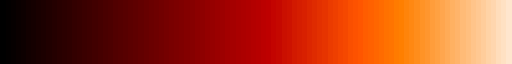

In [115]:
# create a good colormap
og_cmap = plt.get_cmap("gist_heat")
colors = [(*og_cmap(i)[:3], 1) for i, c in zip(np.linspace(0, .95, 100), np.linspace(1, 1,100))]
heat_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
heat_cmap

/Users/dklink/opt/miniconda3/envs/kauai/lib/python3.10/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/dklink/opt/miniconda3/envs/kauai/lib/python3.10/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/dklink/opt/miniconda3/envs/kauai/lib/python3.10/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


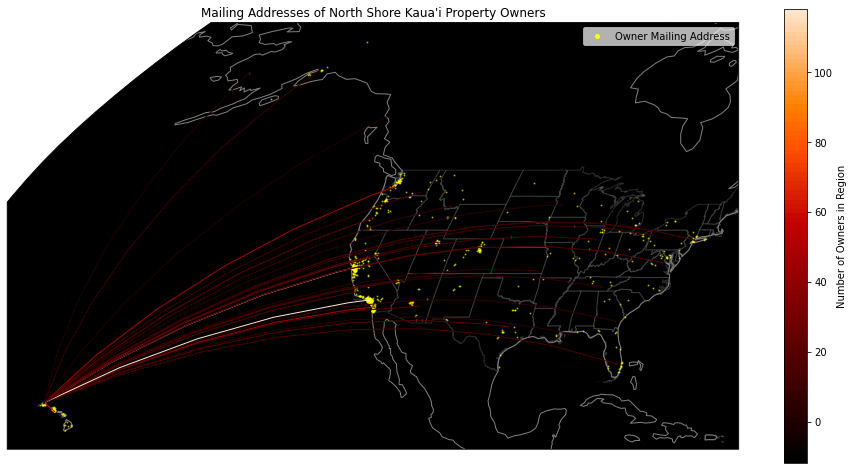

In [168]:
##### FLIGHT LINES BASED ON CLUSTERS #####
# cluster all the mainland properties into 20 clusters and identify centroids
kmeans = KMeans(n_clusters=30, random_state=0).fit(owner_zips[["longitude", "latitude"]])
centroids = kmeans.cluster_centers_
cluster_size = pd.Series(kmeans.labels_).to_frame().groupby(0).size().values

norm = Normalize(vmin=-cluster_size.max()/10, vmax=cluster_size.max())

fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_facecolor("black")
cl = ax.coastlines(color="gray", resolution="110m")

ax.plot(
    owner_zips["longitude"], owner_zips["latitude"],
    '.', markersize=2, color="yellow", alpha=.5, transform=ccrs.Geodetic(),
)

# plot a great circle to each cluster, color dependent on number of points in cluster
for i, (lon, lat) in enumerate(centroids):
    
    color = heat_cmap(norm(cluster_size[i]))

    line = ax.plot(
        [NS_lon, lon],
        [NS_lat, lat],
        linewidth=1, color=color, transform=ccrs.Geodetic(),
    )
    ax.plot(lon, lat, ">", color=color, markersize=1, transform=ccrs.Geodetic())
    
plt.legend(fontsize=10, loc="upper right", framealpha=.7,handles=[
    Line2D([0], [0], marker='o', linewidth=0, color="yellow",
           label="Owner Mailing Address", markersize=4),
    ])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=heat_cmap), shrink=.65, label="Number of Owners in Region")
plt.tight_layout()
plt.autoscale(False)
plt.title("Mailing Addresses of North Shore Kaua'i Property Owners")
usa[usa.STUSPS != "AK"].plot(ax=ax, transform=ccrs.Geodetic(), facecolor="black", edgecolor="gray", alpha=.3)
fig.savefig("../final_figures/ownership_map_v2.png", dpi=500)

In [178]:
print(np.sort(cluster_size))
centroids[np.argsort(cluster_size)]

[  1   1   4   5   5   7   7   9  10  10  11  11  12  14  15  15  15  18
  18  18  20  20  22  27  31  48  48  58 116 118]


array([[-161.7558    ,   60.7922    ],
       [-131.6832    ,   55.372     ],
       [ -88.403975  ,   30.126375  ],
       [ -95.25798   ,   37.33206   ],
       [ -95.6685    ,   44.92942   ],
       [ -85.38175714,   35.48328571],
       [ -82.23854286,   31.55604286],
       [-107.29767778,   36.92645556],
       [-150.2893    ,   61.02449   ],
       [-112.33104   ,   44.81496   ],
       [ -83.91798182,   42.38290909],
       [-118.11157273,   46.38706364],
       [ -80.1343    ,   41.45184167],
       [ -88.56686429,   40.95917857],
       [-115.17062667,   36.13193333],
       [-111.7964    ,   40.60718667],
       [ -80.63306   ,   26.63877333],
       [-110.87640556,   33.25445   ],
       [ -73.81651111,   40.85951667],
       [ -77.53963333,   38.24781667],
       [ -97.20166   ,   30.896095  ],
       [-119.929615  ,   34.953335  ],
       [-123.10641364,   43.4415    ],
       [-120.6992963 ,   38.85463704],
       [-105.06144194,   40.04816129],
       [-122.54207083,   

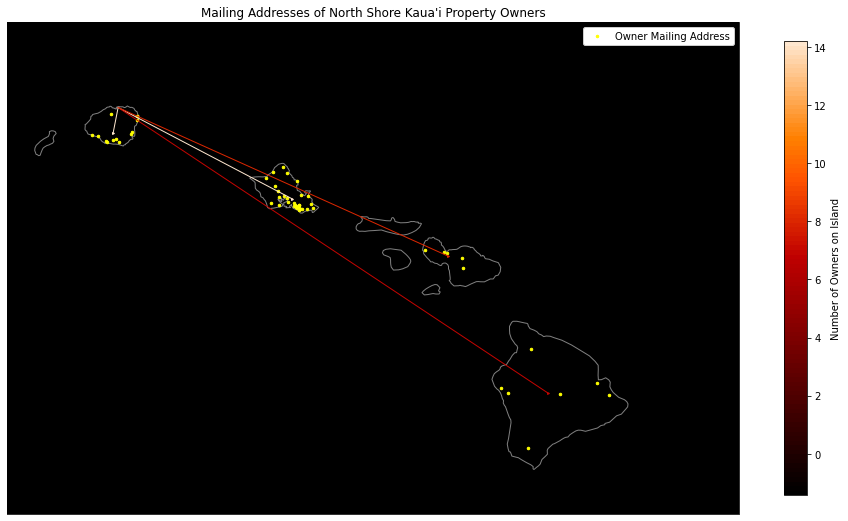

In [158]:
# zoom on hawaii
##### FLIGHT LINES BASED ON CLUSTERS #####
# cluster all the mainland properties into 20 clusters and identify centroids
kmeans = KMeans(n_clusters=75, random_state=0).fit(owner_zips[["longitude", "latitude"]])
centroids = kmeans.cluster_centers_
centroids = centroids[centroids[:, 1] < 25]  # only look at hawaii
cluster_size = pd.Series(kmeans.labels_).to_frame().groupby(0).size().values

norm = Normalize(vmin=-cluster_size.max()/5/10, vmax=cluster_size.max()/5)

fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor("black")
cl = ax.coastlines(color="gray", resolution="10m")

good_zips = owner_zips[owner_zips.OwnerZip != 96769]  # exclude poorly geocoded point between Ni'ihau and Kaua'i
ax.plot(
    good_zips["longitude"], good_zips["latitude"],
    '.', markersize=5, color="yellow", alpha=1, transform=ccrs.Geodetic(),
    label="Owner Mailing Address",
)

# plot a great circle to each cluster, color dependent on number of points in cluster
for i, (lon, lat) in enumerate(centroids):
    color = heat_cmap(norm(cluster_size[i]))

    line = ax.plot(
        [NS_lon, lon],
        [NS_lat, lat],
        linewidth=1, color=color, transform=ccrs.Geodetic(),
    )
    ax.plot(lon, lat, ">", color=color, markersize=2, transform=ccrs.Geodetic())
    
plt.legend(fontsize=10, loc="upper right", framealpha=1)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=heat_cmap), shrink=.65, label="Number of Owners on Island")
plt.tight_layout()
ax.set_xlim([-160.5, -153.8])
ax.set_ylim([18.5, 23])
plt.title("Mailing Addresses of North Shore Kaua'i Property Owners")
fig.savefig("../final_figures/ownership_map_v2_hawaii.png", dpi=500)


,OwnerZip,num_owners,latitude,longitude
